# A Empresa Cardio Catch Diseases ( CCD )

   A Cadio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O
seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença
cardiovascular por um certo preço.

   Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas.
A precisão atual do diagnóstico varia entre 55\% e 65\%, devido a complexidade do diagnóstico e também da
fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os
aparelhos e a folha de pagamento dos analistas, gira em torno de RS 1.000,00.

   O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de
especialistas, o cliente paga RS 500,00 a cada 5\% de acurácia acima de 50\%\. Por exemplo, para uma precisão de
55\% , o diagnóstico custa RS 500,00 para o cliente, para uma precisão de 60\% , o valor é de RS 1000,00 e assim
por diante. Se a precisão do diagnóstico for 50\% o cliente não paga por ele.

   Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma
operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa
instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.

   O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos. Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como uma precisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: ( Ele provavelmente irá fazer essas pergunta no dia da sua apresentação. )
1. Qual a Acurácia e a Precisão da ferramenta?
2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
3. Qual a Confiabilidade do resultado dados pela nova ferramenta?


## Entendimento sobre o problema

Criar um modelo de classificação com uma precisão que seja rentável para a operação, ou seja, acima de 60\% para cima.

Com essa nova performance, verificar o ganho da operação e identificar possíveis melhorias. 

O caso permite algumas suposições de hipóteses relacionadas às variáveis que deverão ser validadas durante a análise.

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Dictionary</p></div>

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

*All of the dataset values were collected at the moment of medical examination*.

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Imports</p></div>

In [ ]:
import pandas as pd

import numpy as np

import seaborn as sns

import inflection

import matplotlib.pyplot as plt

from IPython.core.display           import HTML

from sklearn.model_selection import train_test_split, cross_val_score


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 18
    
    display( HTML('<style>.container{width:100% !important; }</style'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()

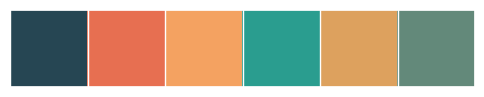

In [41]:
# Configurações de Layout, Matlab e Seaborn
LAYOUT_PALETTE = ["#264653", "#e76f51", "#f4a261", "#2a9d8f", "#dda15e", "#63897a"]

sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#e76f51")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

In [42]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Pichau\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['matrix', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [43]:
#!jt -t gruvboxd -T -N -kl

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Helper Functions</p></div>

In [113]:
def column_clean(df):
    for i in range(len(df.columns)):
        df.columns.values[i] = df.columns[i].strip().replace(' ', '_').replace('/', '_')
    
    snakecase = lambda x: inflection.underscore( x )
    df.columns = list(map( snakecase, df.columns ))
    
    rename_dict = {
    'gluc': 'glucose_level',
    'alco': 'if_alcohol',
    'smoke': 'if_smoke',
    'active': 'if_active'
    }

    
    df.rename(columns=rename_dict, inplace=True)
    return df 

def summary_stats(df):
    # central tendency: mean, median   
    numerical_features = df.select_dtypes(include = ['number']).columns.values
    df = df[numerical_features]
        
    
    mean_ = pd.DataFrame(df.apply(np.mean))
    std_ = pd.DataFrame(df.apply(np.std))
    median_ = pd.DataFrame(df.apply(np.median))
    
    min_ = pd.DataFrame(df.apply(min))
    max_ = pd.DataFrame(df.apply(max))
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    q1_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,25)))
    q3_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,75)))
    
    skewness_= pd.DataFrame(df.apply(lambda x: x.skew()))
    kurtosis_ = pd.DataFrame(df.apply(lambda x: x.kurtosis()))
    
    summary = pd.concat([mean_, std_, median_, min_, max_, range_, q1_,q3_, skewness_, kurtosis_],axis=1)
    summary.columns = ['mean','std','median','min','max', 'range', '25%','75%', 'skew', 'kurt']
 

    #cm = sns.light_palette("#e76f51", as_cmap = True)
    
    display(summary.style.format('{:.2f}'))
            #.background_gradient(subset=(summary.index[2:],summary.columns[:])))#,cmap=cm))
        
def pressure_adjustment(x):
    if x == 1 or x == 2:
        return x * 100
    elif 2 < x <= 24:
        return x * 10
    elif 24 < x <= 240:
        return x
    elif 241 <= x <= 2400:
        return x / 10
    elif x < 100:
        return x
    else:
        return x / 100
    


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Loading</p></div>

In [114]:
data_raw = pd.read_csv('data/cardio_train.csv', delimiter=';')

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Description</p></div>

In [115]:
print('Número de linhas: {}'.format(data_raw.shape[0]))
print('Número de colunas: {}'.format(data_raw.shape[1]))

Número de linhas: 70000
Número de colunas: 13


In [116]:
# checking data info
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preprocessing</p></div>

In [117]:
# safe copy
df_preprocessing = data_raw.copy()

In [118]:
# cleaning columns ( spaces, lowercase, rename )
column_clean(df_preprocessing);

In [119]:
# Converting age : days to years
df_preprocessing['age'] = (df_preprocessing['age']/365).astype(np.int64)

# Formating pressure data

df_preprocessing['ap_hi'] = df_preprocessing['ap_hi'].apply( lambda x : pressure_adjustment(x))
df_preprocessing['ap_lo'] = df_preprocessing['ap_lo'].apply( lambda x : pressure_adjustment(x))

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Exploratory Data Analysis</p></div>

In [120]:
# safe copy
data_eda = df_preprocessing.copy()

In [121]:
# checking target variable
data_eda['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [122]:
# pre adjusments summary - without preprocessing
summary_stats(data_raw)

,mean,std,median,min,max,range,25%,75%,skew,kurt
id,49972.42,28851.10,50001.50,0.00,99999.00,99999.00,25006.75,74889.25,-0.00,-1.20
age,19468.87,2467.23,19703.00,10798.00,23713.00,12915.00,17664.00,21327.00,-0.31,-0.82
gender,1.35,0.48,1.00,1.00,2.00,1.00,1.00,2.00,0.63,-1.60
height,164.36,8.21,165.00,55.00,250.00,195.00,159.00,170.00,-0.64,7.94
weight,74.21,14.40,72.00,10.00,200.00,190.00,65.00,82.00,1.01,2.59
ap_hi,128.82,154.01,120.00,-150.00,16020.00,16170.00,120.00,140.00,85.30,7580.07
ap_lo,96.63,188.47,80.00,-70.00,11000.00,11070.00,80.00,90.00,32.11,1425.91
cholesterol,1.37,0.68,1.00,1.00,3.00,2.00,1.00,2.00,1.59,0.99
gluc,1.23,0.57,1.00,1.00,3.00,2.00,1.00,1.00,2.40,4.29
smoke,0.09,0.28,0.00,0.00,1.00,1.00,0.00,0.00,2.91,6.44


In [123]:
# summary with preprocessing
summary_stats(data_eda)

,mean,std,median,min,max,range,25%,75%,skew,kurt
id,49972.42,28851.10,50001.50,0.00,99999.00,99999.00,25006.75,74889.25,-0.00,-1.20
age,52.84,6.77,53.00,29.00,64.00,35.00,48.00,58.00,-0.31,-0.82
gender,1.35,0.48,1.00,1.00,2.00,1.00,1.00,2.00,0.63,-1.60
height,164.36,8.21,165.00,55.00,250.00,195.00,159.00,170.00,-0.64,7.94
weight,74.21,14.40,72.00,10.00,200.00,190.00,65.00,82.00,1.01,2.59
ap_hi,126.97,17.30,120.00,-150.00,240.00,390.00,120.00,140.00,0.59,5.96
ap_lo,81.66,10.25,80.00,-70.00,208.80,278.80,80.00,90.00,0.81,9.59
cholesterol,1.37,0.68,1.00,1.00,3.00,2.00,1.00,2.00,1.59,0.99
glucose_level,1.23,0.57,1.00,1.00,3.00,2.00,1.00,1.00,2.40,4.29
if_smoke,0.09,0.28,0.00,0.00,1.00,1.00,0.00,0.00,2.91,6.44


In [124]:
# Transforming categorical variables to EDA

data_eda.columns

data_eda['gender'] = data_eda['gender'].apply( lambda x: 'Female' if x == 1 else 'Male')
data_eda['cholesterol'] = data_eda['cholesterol'].map( lambda x: 'Normal' if x == 1 else 'Above Normal' if x == 2 else 'Well Above Normal')
data_eda['glucose_level'] = data_eda['glucose_level'].map(lambda x: 'Normal' if x == 1 else 'Above Normal' if x == 2 else 'Well Above Normal')
data_eda['if_smoke'] = data_eda['if_smoke'].apply( lambda x: 'No' if x == 0 else 'Yes')
data_eda['if_alcohol'] = data_eda['if_alcohol'].apply( lambda x: 'No' if x == 0 else 'Yes')
data_eda['if_active'] = data_eda['if_active'].apply( lambda x: 'No' if x == 0 else 'Yes')


In [125]:
# summary after data changes in pressure
summary_stats(data_eda)

,mean,std,median,min,max,range,25%,75%,skew,kurt
id,49972.42,28851.10,50001.50,0.00,99999.00,99999.00,25006.75,74889.25,-0.00,-1.20
age,52.84,6.77,53.00,29.00,64.00,35.00,48.00,58.00,-0.31,-0.82
height,164.36,8.21,165.00,55.00,250.00,195.00,159.00,170.00,-0.64,7.94
weight,74.21,14.40,72.00,10.00,200.00,190.00,65.00,82.00,1.01,2.59
ap_hi,126.97,17.30,120.00,-150.00,240.00,390.00,120.00,140.00,0.59,5.96
ap_lo,81.66,10.25,80.00,-70.00,208.80,278.80,80.00,90.00,0.81,9.59
cardio,0.50,0.50,0.00,0.00,1.00,1.00,0.00,1.00,0.00,-2.00


In [126]:
num_attributes = data_eda.select_dtypes( include=['int64','float64'])
cat_attributes = data_eda.select_dtypes( exclude=['int64','float64'])

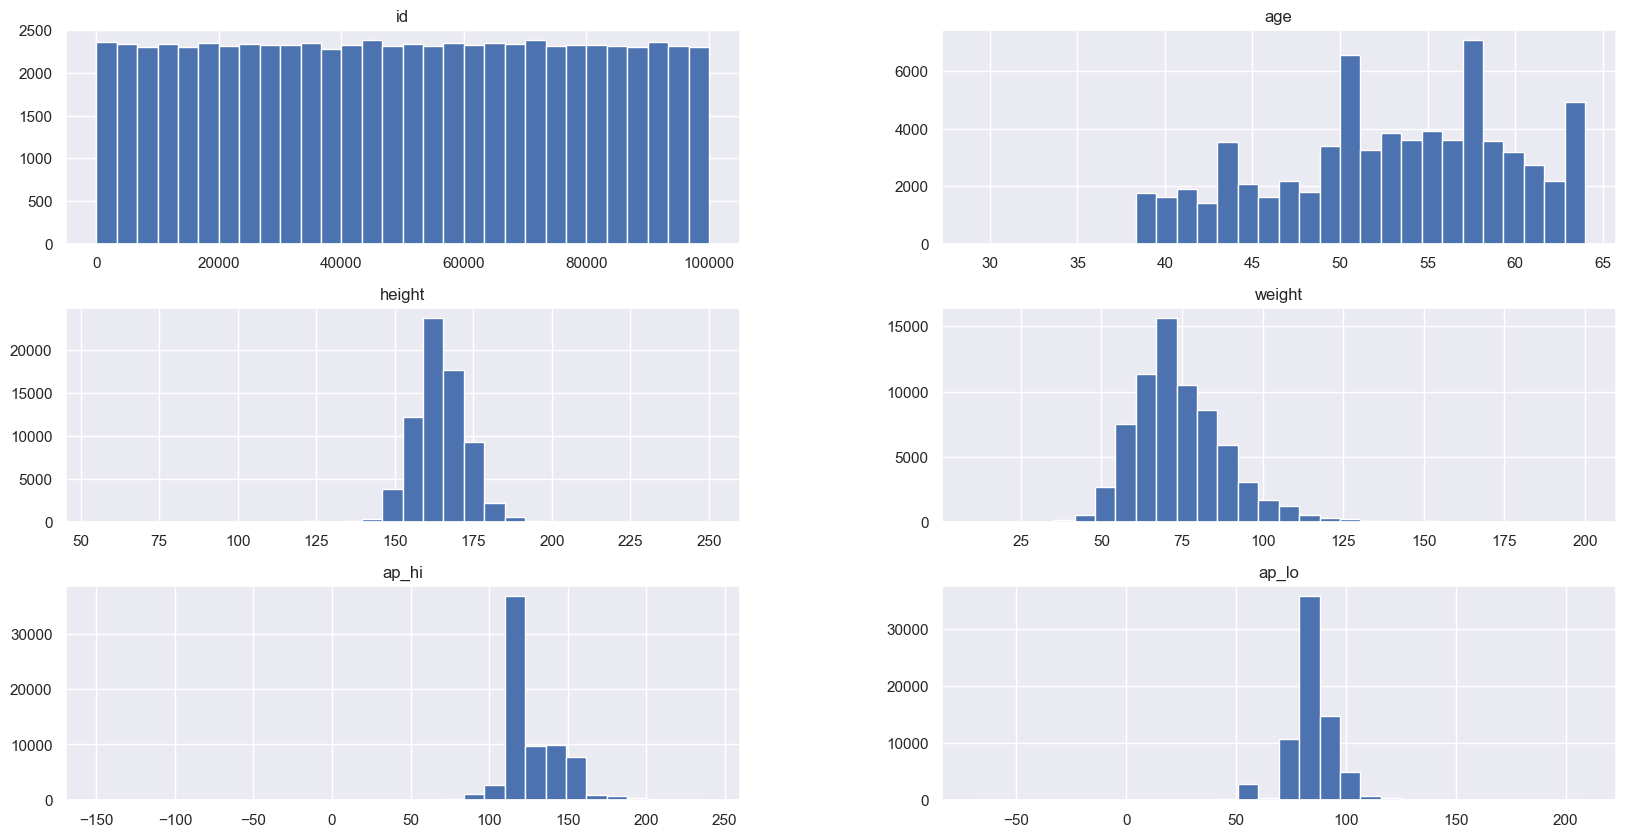

In [127]:
num_attributes.drop('cardio', axis=1).hist( bins = 30 );

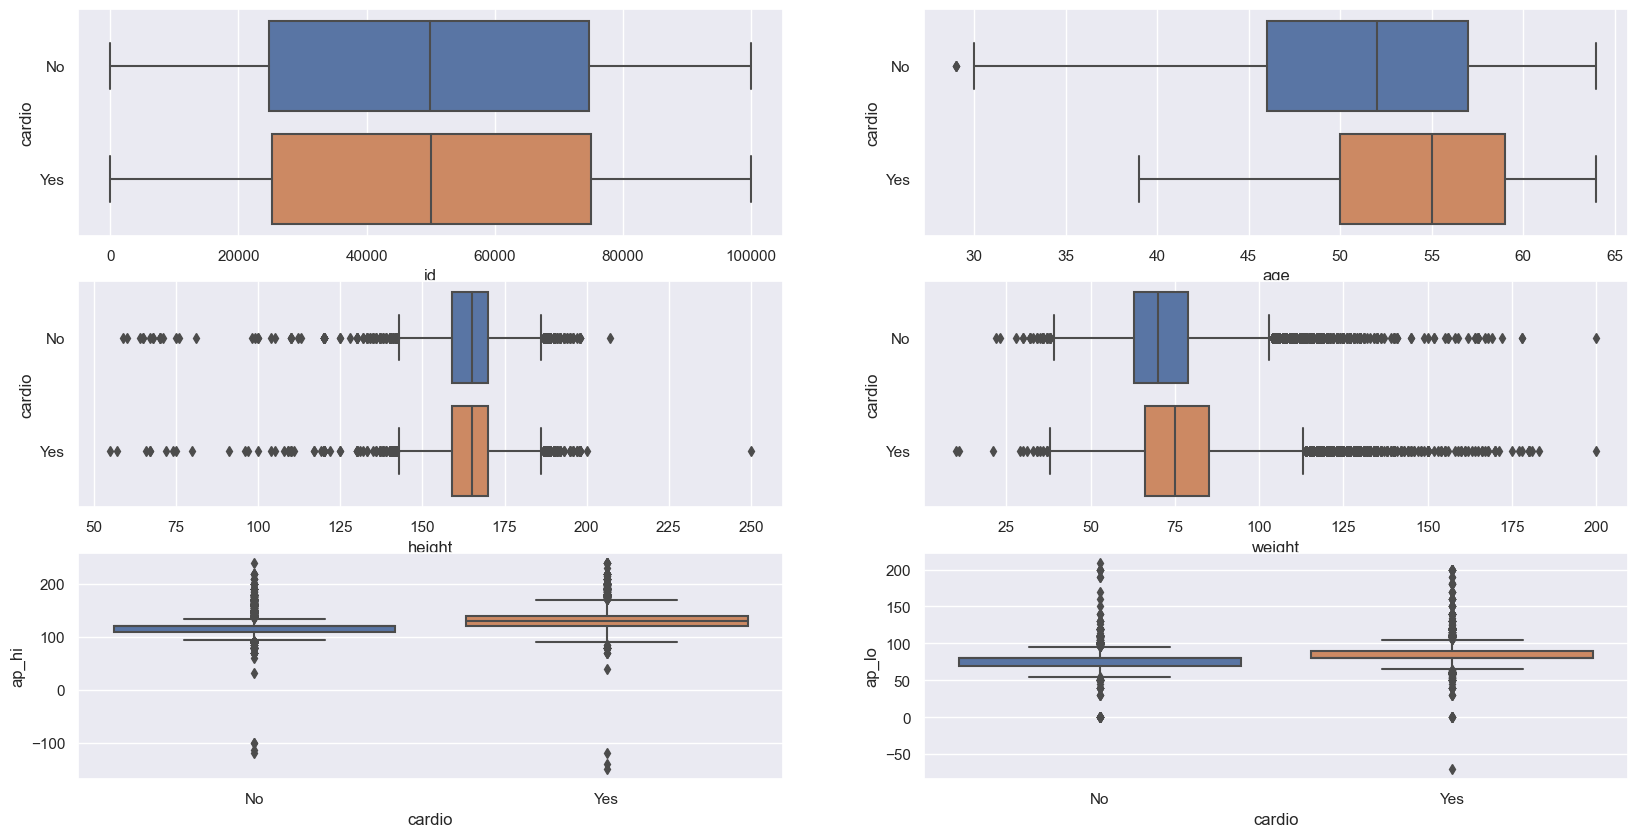

In [128]:
# Verifying numerical variables with target
data_aux = data_eda.copy()
data_aux['cardio'] = data_aux['cardio'].apply( lambda x: 'No' if x == 0 else 'Yes')

plt.subplot( 3, 2, 1)
sns.boxplot( y = 'cardio', x = 'id', data= data_aux)

plt.subplot( 3, 2, 2)
sns.boxplot( y = 'cardio', x = 'age', data= data_aux)

plt.subplot( 3, 2, 3)
sns.boxplot( y = 'cardio', x = 'height', data= data_aux)

plt.subplot( 3, 2, 4)
sns.boxplot( y = 'cardio', x = 'weight', data= data_aux)

plt.subplot( 3, 2, 5)
sns.boxplot( x = 'cardio', y = 'ap_hi', data= data_aux)

plt.subplot( 3, 2, 6)
sns.boxplot( x = 'cardio', y = 'ap_lo', data= data_aux)

plt.show()

<AxesSubplot:xlabel='if_active', ylabel='count'>

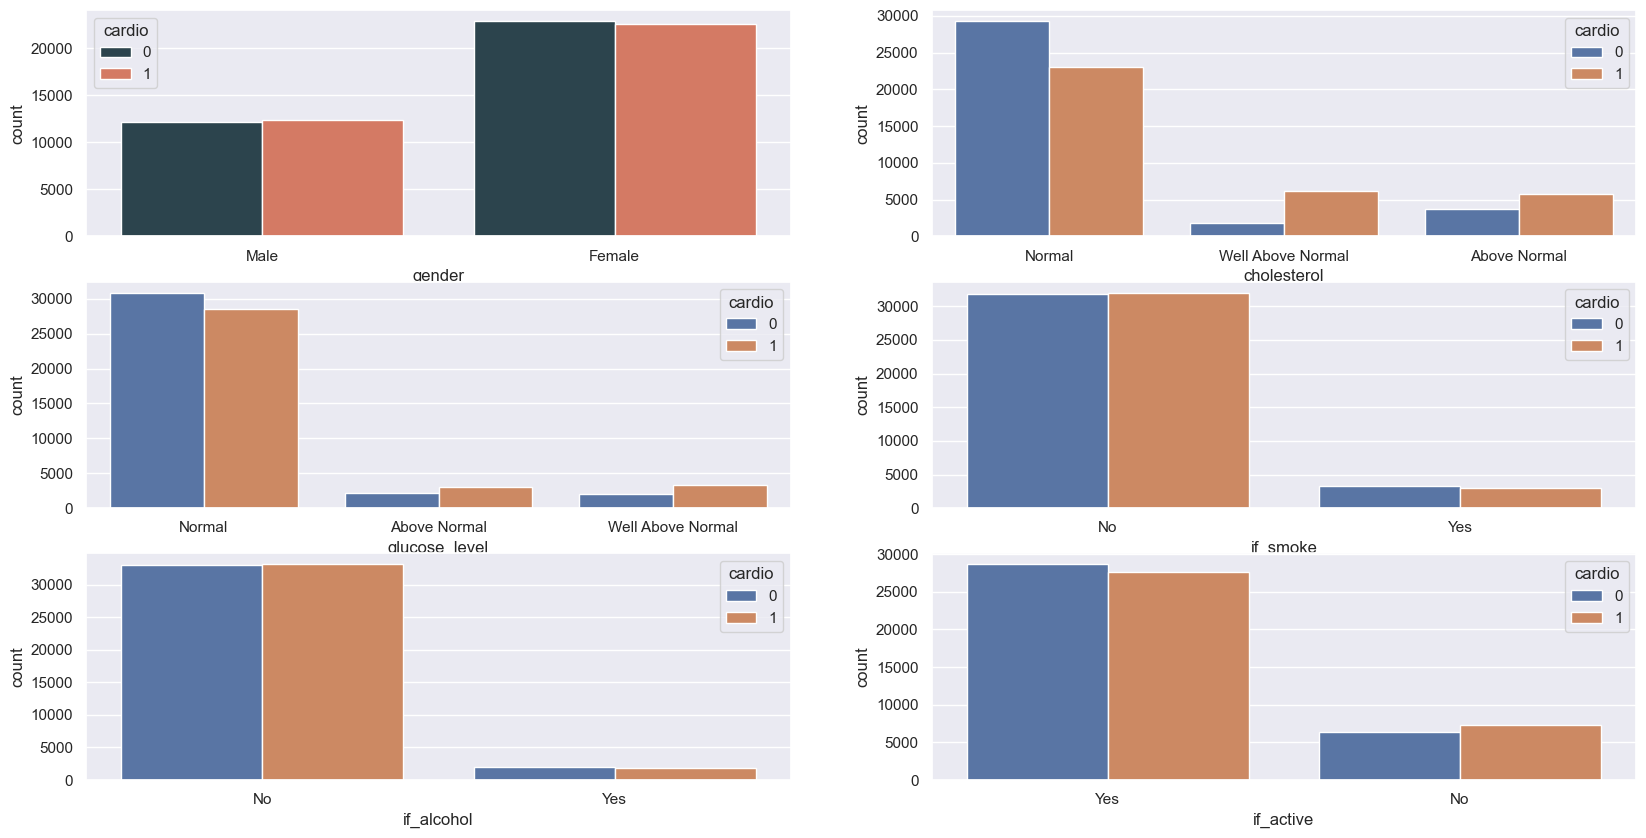

In [129]:
# Verifying categorical variables with target

plt.subplot( 3, 2, 1)
sns.countplot(x = 'gender', hue ='cardio', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 2)
sns.countplot(x = 'cholesterol', hue ='cardio', data= data_eda )

plt.subplot( 3, 2, 3)
sns.countplot(x = 'glucose_level', hue ='cardio', data= data_eda )

plt.subplot( 3, 2, 4)
sns.countplot(x = 'if_smoke', hue ='cardio', data= data_eda )

plt.subplot( 3, 2, 5)
sns.countplot(x = 'if_alcohol', hue ='cardio', data= data_eda )

plt.subplot( 3, 2, 6)
sns.countplot(x = 'if_active', hue ='cardio', data= data_eda )


### Multivaried Analysis : Categorical

In [130]:
from scipy                          import stats as ss

In [131]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

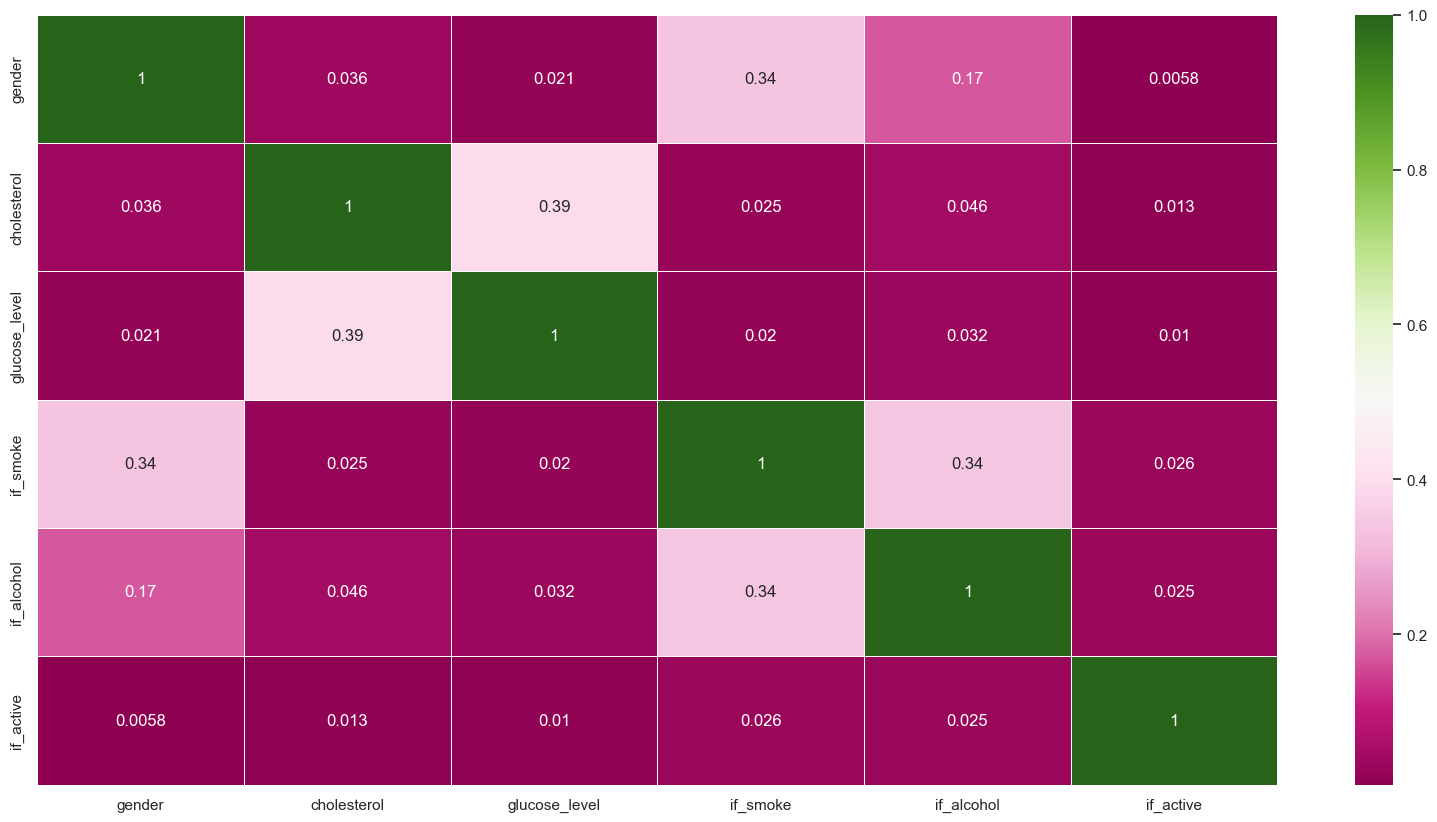

In [132]:
# only categorical data
a = data_eda.select_dtypes( include= 'object' )

# Calculate Cramer V
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['cholesterol'])
a3 = cramer_v(a['gender'], a['glucose_level'])
a4 = cramer_v(a['gender'], a['if_smoke'])
a5 = cramer_v(a['gender'], a['if_alcohol'])
a6 = cramer_v(a['gender'], a['if_active'])

a7 = cramer_v(a['cholesterol'], a['gender'])
a8 = cramer_v(a['cholesterol'], a['cholesterol'])
a9 = cramer_v(a['cholesterol'], a['glucose_level'])
a10 = cramer_v(a['cholesterol'], a['if_smoke'])
a11 = cramer_v(a['cholesterol'], a['if_alcohol'])
a12 = cramer_v(a['cholesterol'], a['if_active'])

a13 = cramer_v(a['glucose_level'], a['gender'])
a14 = cramer_v(a['glucose_level'], a['cholesterol'])
a15 = cramer_v(a['glucose_level'], a['glucose_level'])
a16 = cramer_v(a['glucose_level'], a['if_smoke'])
a17 = cramer_v(a['glucose_level'], a['if_alcohol'])
a18 = cramer_v(a['glucose_level'], a['if_active'])

a19 = cramer_v(a['if_smoke'], a['gender'])
a20 = cramer_v(a['if_smoke'], a['cholesterol'])
a21 = cramer_v(a['if_smoke'], a['glucose_level'])
a22 = cramer_v(a['if_smoke'], a['if_smoke'])
a23 = cramer_v(a['if_smoke'], a['if_alcohol'])
a24 = cramer_v(a['if_smoke'], a['if_active'])

a25 = cramer_v(a['if_alcohol'], a['gender'])
a26 = cramer_v(a['if_alcohol'], a['cholesterol'])
a27 = cramer_v(a['if_alcohol'], a['glucose_level'])
a28 = cramer_v(a['if_alcohol'], a['if_smoke'])
a29 = cramer_v(a['if_alcohol'], a['if_alcohol'])
a30 = cramer_v(a['if_alcohol'], a['if_active'])

a31 = cramer_v(a['if_active'], a['gender'])
a32 = cramer_v(a['if_active'], a['cholesterol'])
a33 = cramer_v(a['if_active'], a['glucose_level'])
a34 = cramer_v(a['if_active'], a['if_smoke'])
a35 = cramer_v(a['if_active'], a['if_alcohol'])
a36 = cramer_v(a['if_active'], a['if_active'])
# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6],
               'cholesterol': [a7, a8, a9, a10, a11, a12],
               'glucose_level': [a13, a14, a15, a16, a17, a18],
               'if_smoke': [a19, a20, a21, a22, a23, a24],
               'if_alcohol': [a25, a26, a27, a28, a29, a30],
               'if_active': [a31, a32, a33, a34, a35, a36]})
d = d.set_index( d.columns )

sns.heatmap(d, annot=True , cmap= "PiYG", linewidth=.5);

### Insights

- Most patients have good habits as no drinking, smoking and keeping an active routine of exercises
- Cholesterol seems to have a positive correlation with cardiovascular disease
- Same goes for glucose level, both seem to contribute to a higher probability to have a cardio disease.

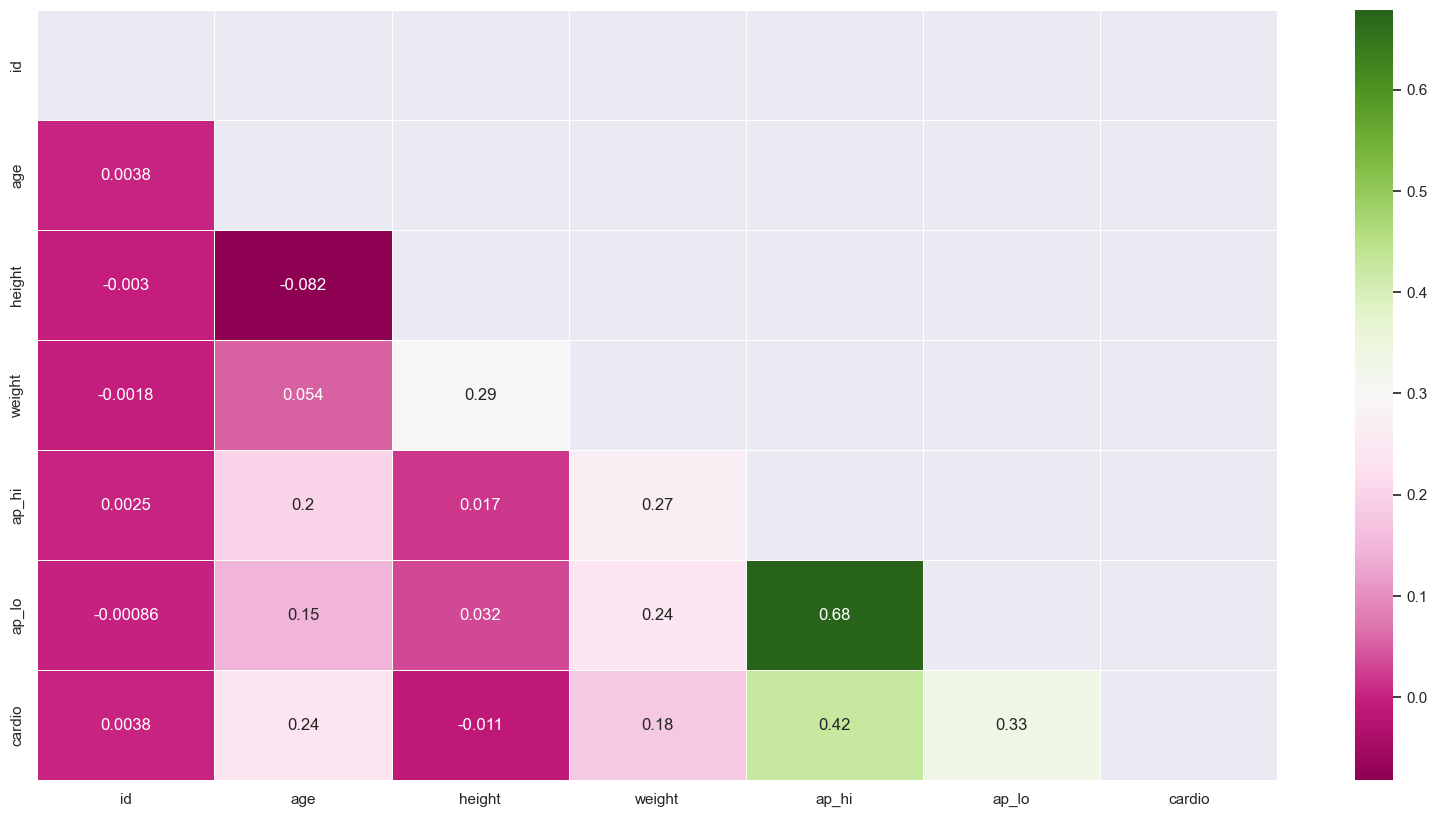

In [133]:
correlation = num_attributes.corr( method= 'pearson')

# getting upper triangle from correlation matrix
matrix = np.triu(correlation)

sns.heatmap( correlation, annot= True, mask= matrix, cmap= "PiYG", linewidth=.5);

## Hypothesis Map

### H1. Pessoas mais velhas tendem a ter doença cardíaca

**Verdadeiro** : pessoas mais velhas tem mais doença cardíaca do que jovens

<AxesSubplot:xlabel='age', ylabel='count'>

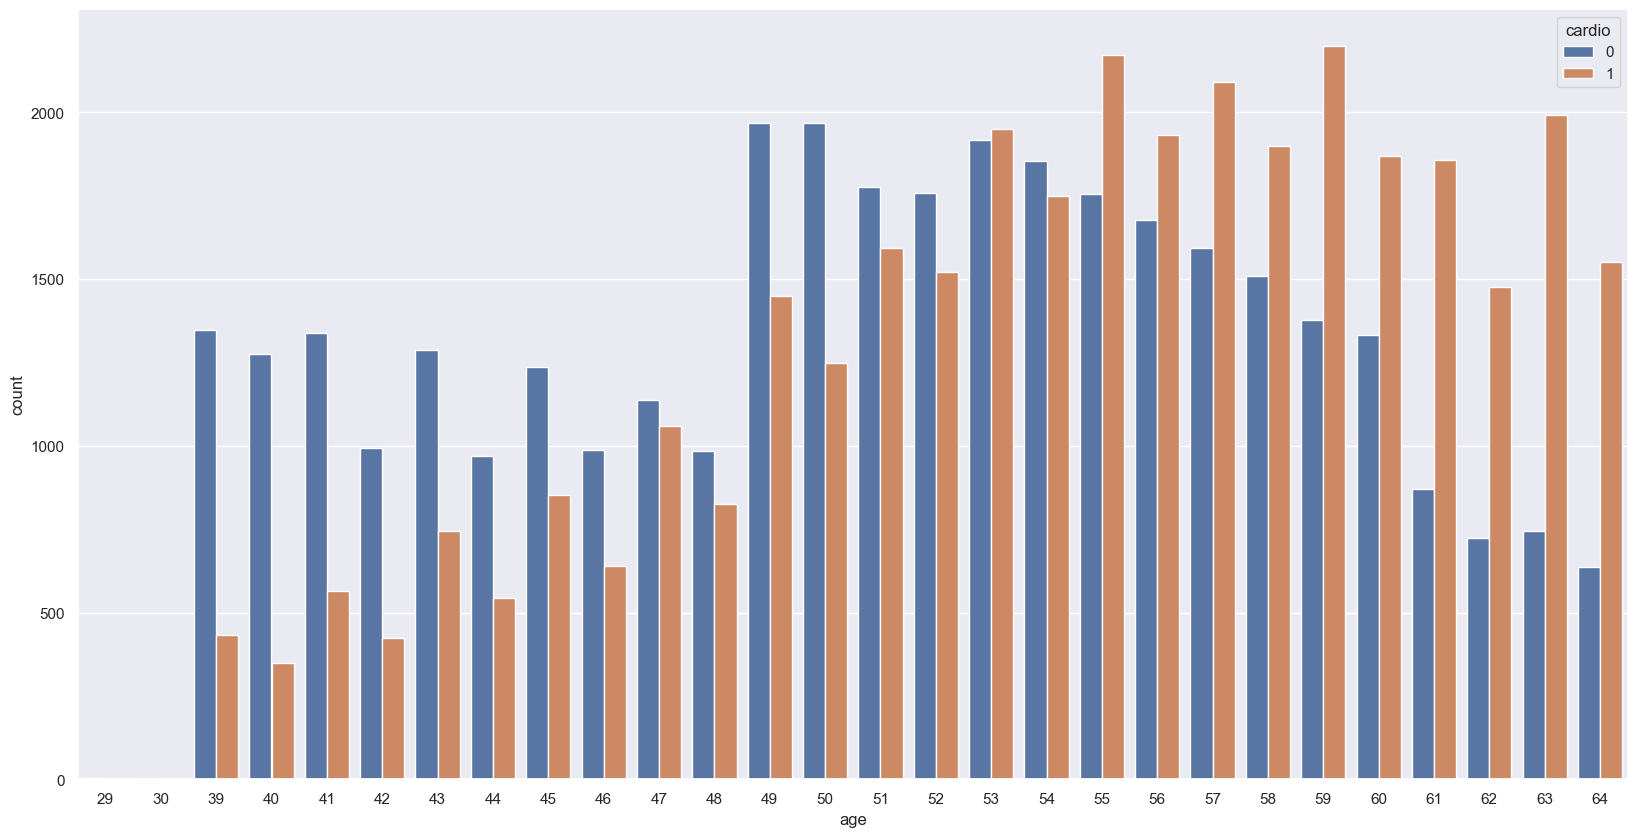

In [134]:
sns.countplot(x='age', hue='cardio', data= data_eda)

### H2. Fumantes tem mais doenças cardíacas que não fumantes
**Indiferente** O fato de fumar não discrimina na doença cardíaca

<AxesSubplot:xlabel='if_smoke', ylabel='count'>

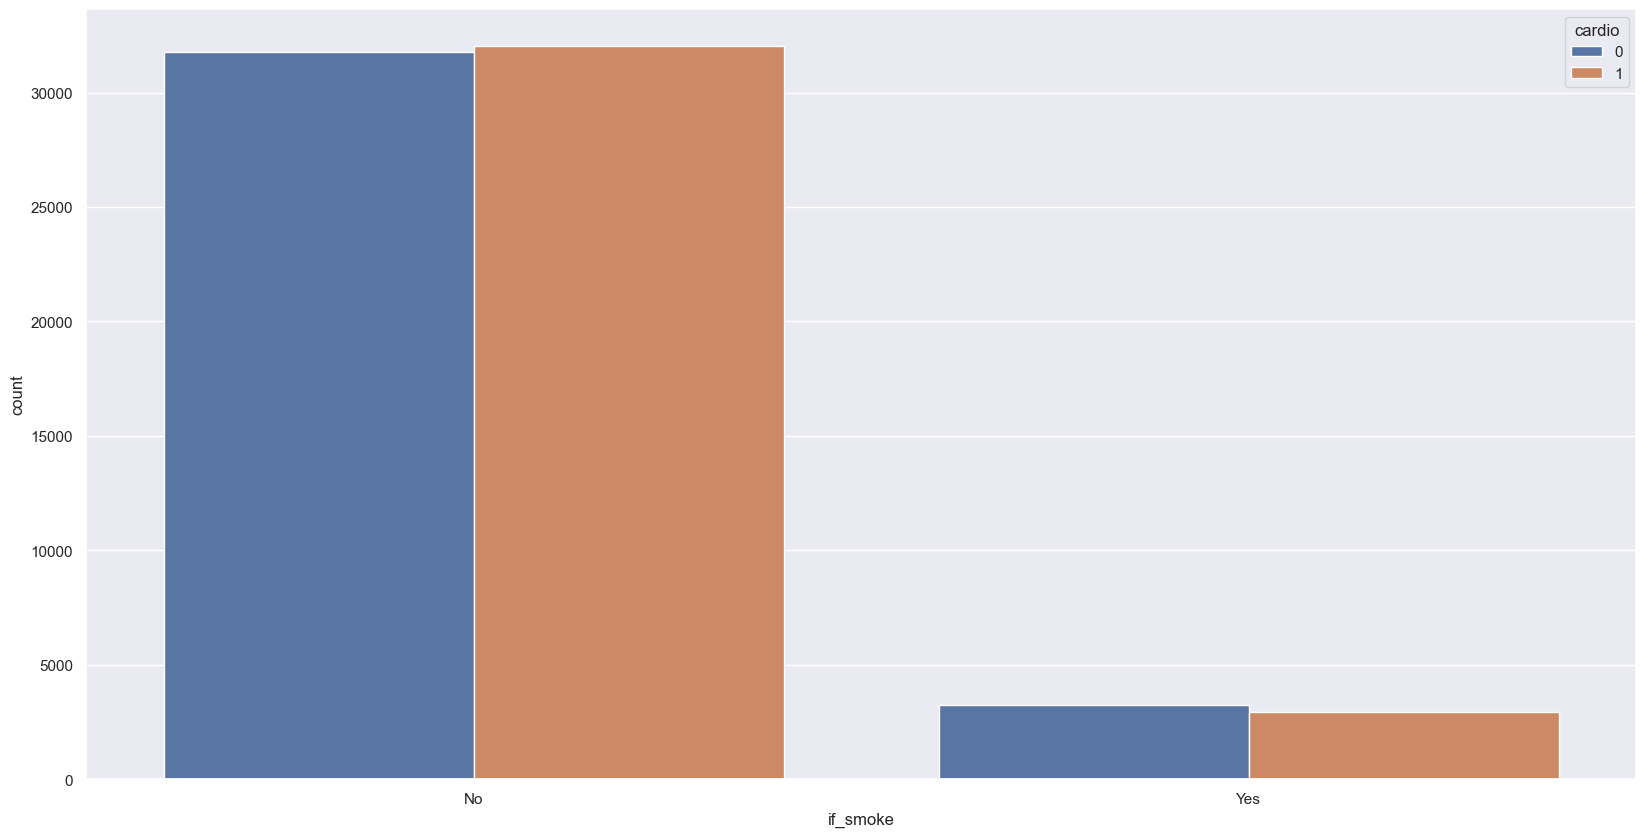

In [135]:
sns.countplot(x='if_smoke', hue='cardio', data= data_eda)

### H3. Pessoas que se exercitam tem menos doença cardíacas que sedentários

**VERDADEIRO**: Pessoas que se exercitam tem menos doenças cardíacas que os sedentários

<AxesSubplot:xlabel='if_active', ylabel='count'>

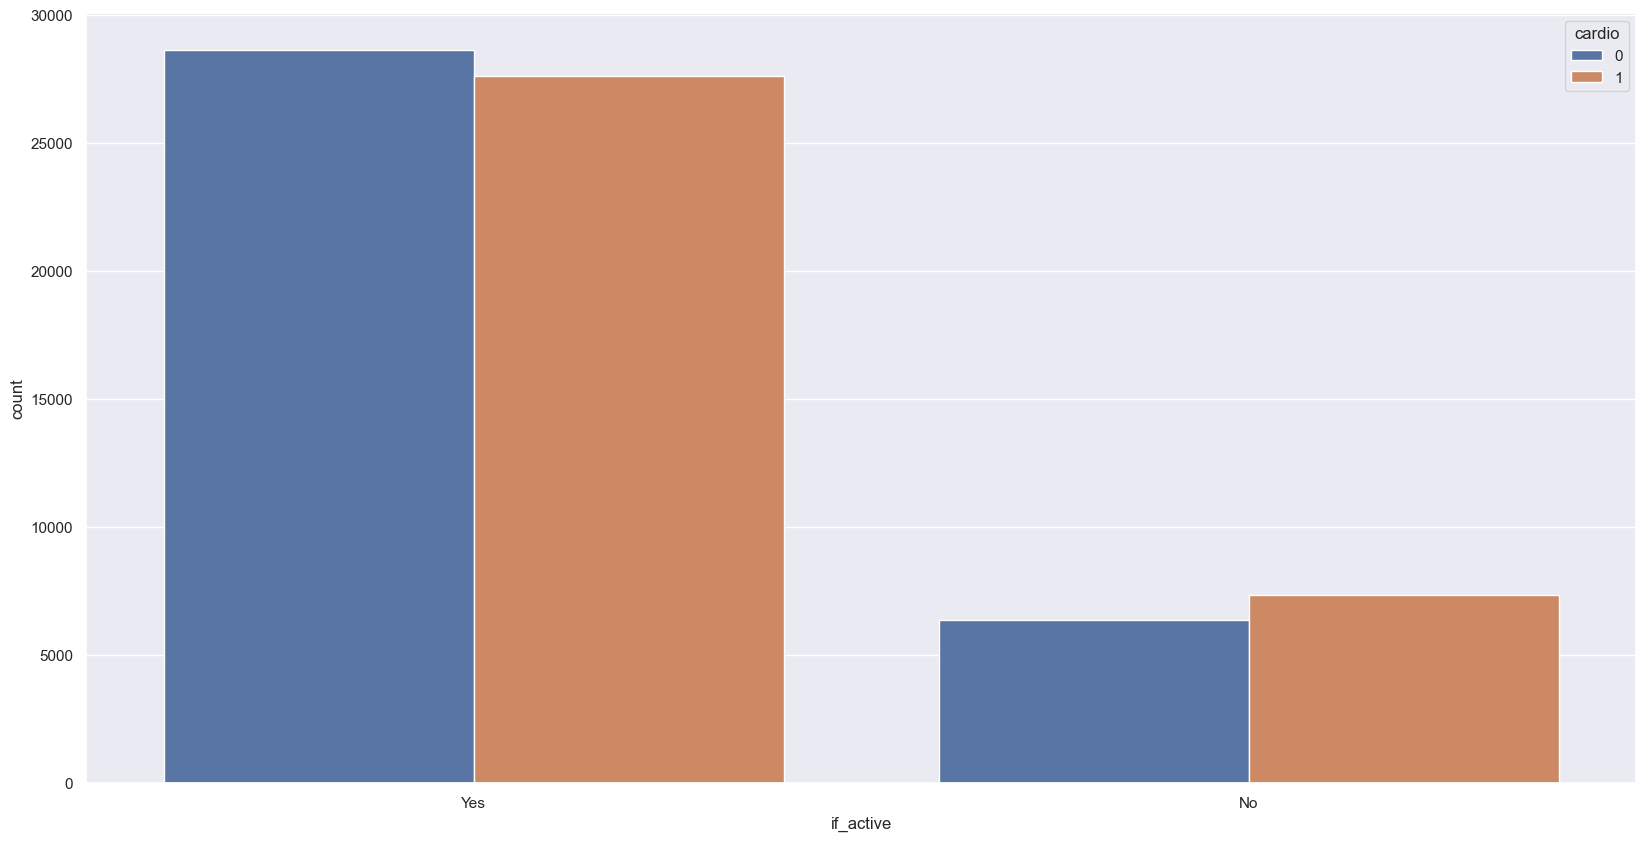

In [136]:
sns.countplot(x='if_active', hue='cardio', data= data_eda)

### H4. Pessoas mais baixas tem mais doenças cardíacas

**FALSO** Não podemos afirmar que pessoas mais baixas tem mais doenças cardíacas que as mais altas.

<AxesSubplot:xlabel='height', ylabel='count'>

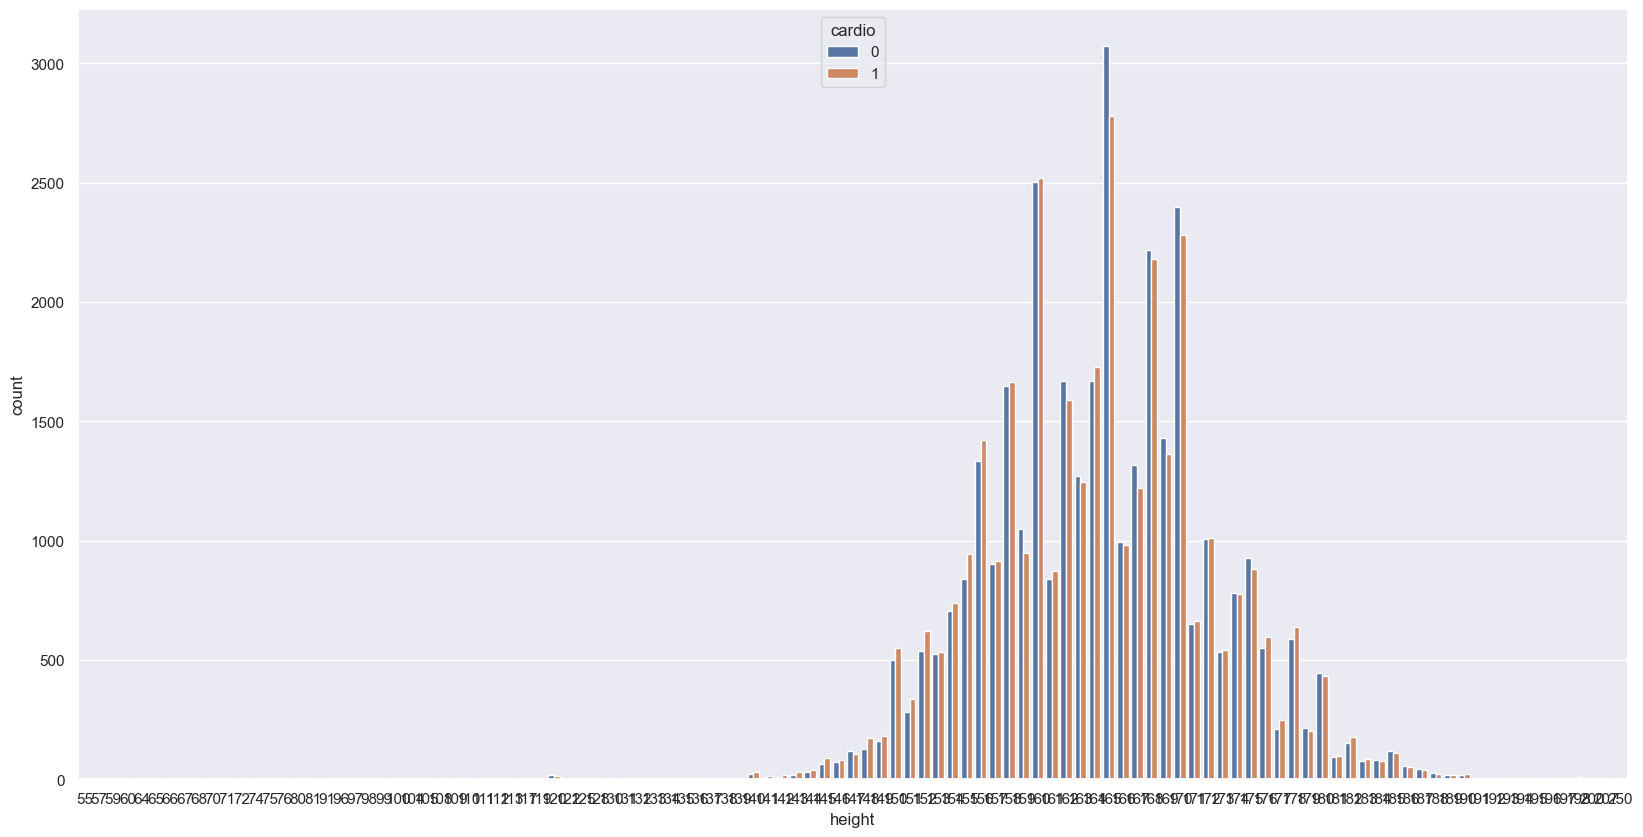

In [137]:
sns.countplot(x='height', hue='cardio', data= data_eda)

### H5. Pessoas mais pesadas tem mais doenças cardíacas

**VERDADEIRO** A partir de 75kg, a maioria das pessoas tem doença cardíacas

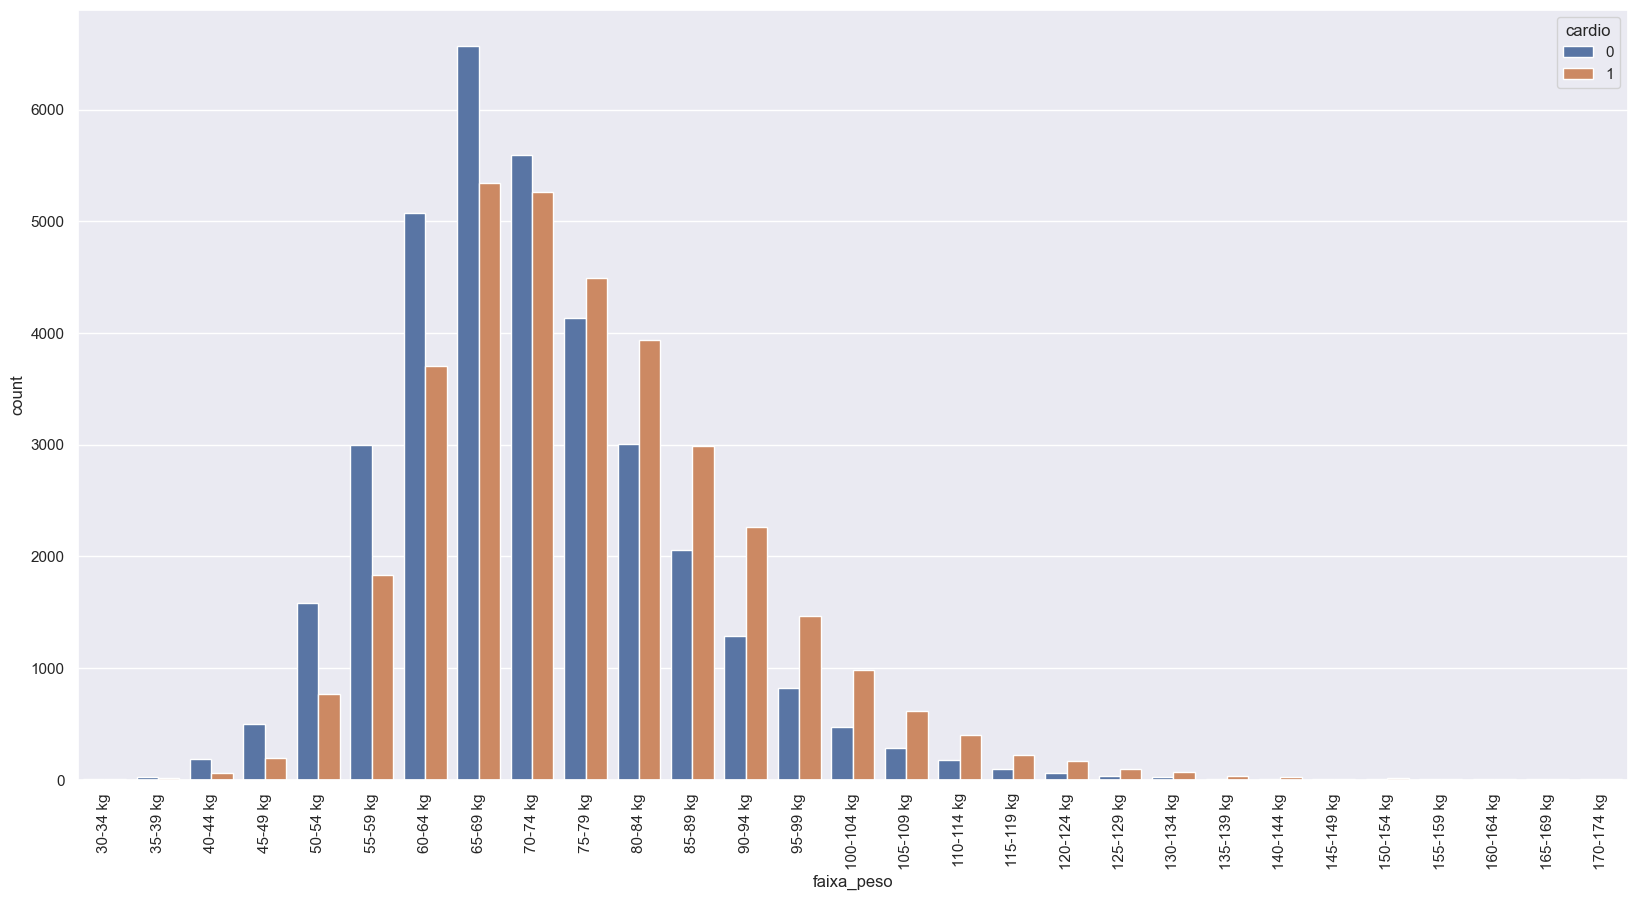

In [138]:
# Criar faixas de peso a cada 5 kg
faixas_peso = range(30, 180, 5)

# Criar rótulos para as faixas
rotulos_faixas = [f'{inicio}-{inicio+4} kg' for inicio in faixas_peso[:-1]]

# Aplicar pd.cut para criar a coluna de faixas de peso
data_eda['faixa_peso'] = pd.cut(data_eda['weight'], bins=faixas_peso, labels=rotulos_faixas, right=False)

# Verificar a contagem de valores em cada faixa
contagem_por_faixa = data_eda['faixa_peso'].value_counts().sort_index()

sns.countplot(x='faixa_peso', hue='cardio', data= data_eda)
plt.xticks(rotation=90);

### H6. Pessoas com pressões mais altas tem mais doenças cardíacas

**VERDADEIRO**: pessoas com pressões elevadas (acima de 120 ap_hi e 80 ap_lo) tendem a ter mais doenças cardíacas

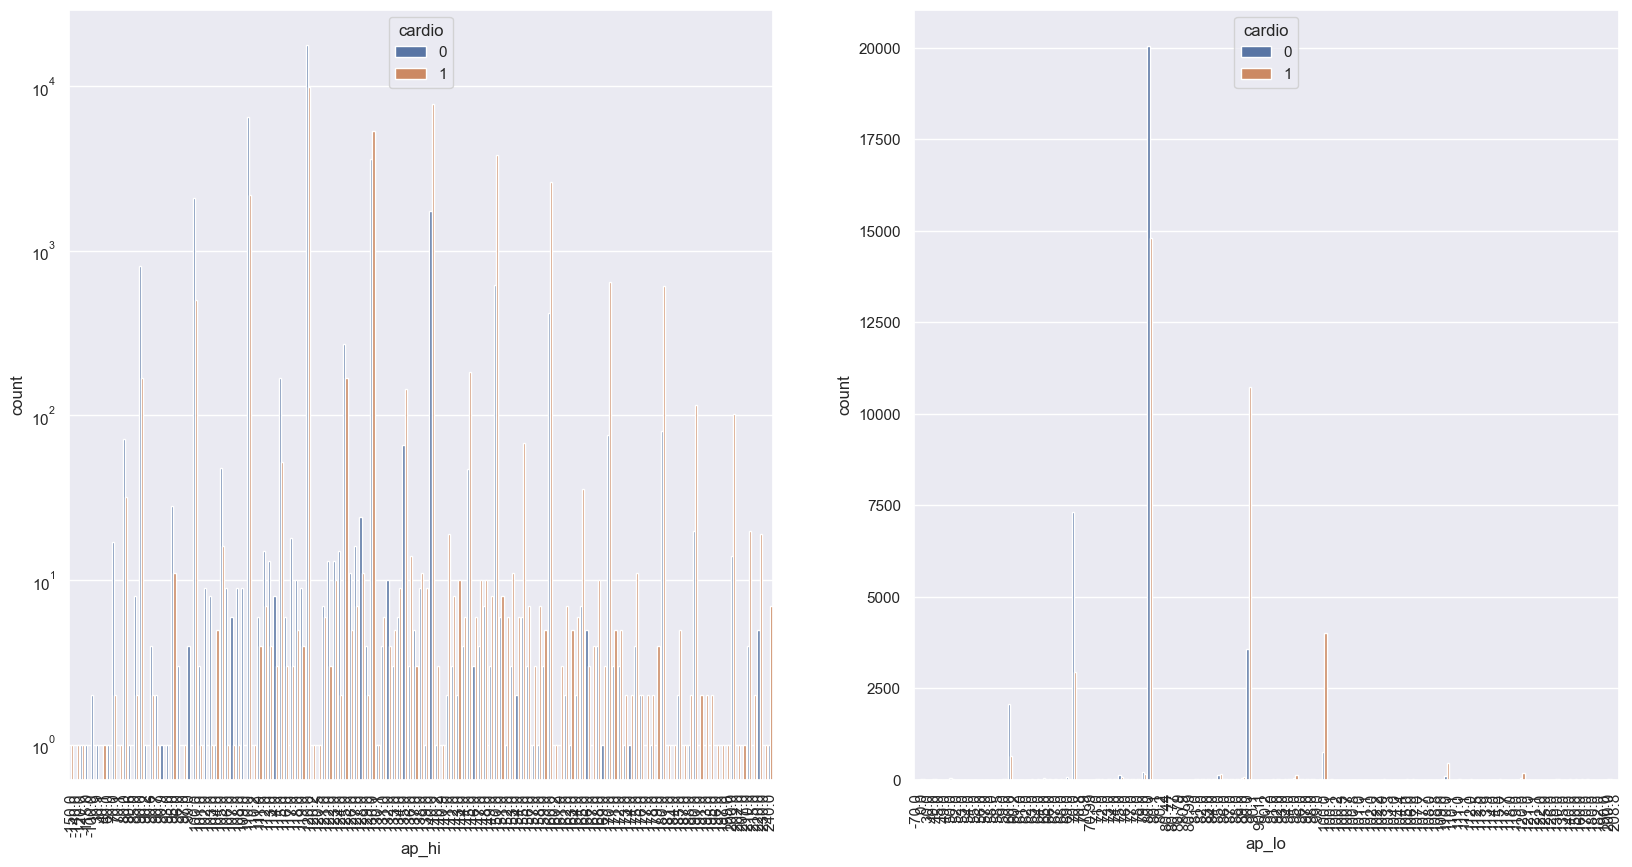

In [139]:
plt.subplot(1, 2, 1)
sns.countplot(x='ap_hi', hue='cardio', data= data_eda)
plt.xticks(rotation=90)
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.countplot(x='ap_lo', hue='cardio', data= data_eda)
plt.xticks(rotation=90);

### H7. Pessoas com pressão negativa tem mais doenças cardíacas

** AVALIAR SITUAÇÕES COM PRESSÃO NEGATIVA

In [140]:
df_aux = data_eda[(data_eda['ap_hi'] < 0) | (data_eda['ap_lo'] < 0)]

In [141]:
df_aux.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,cardio,faixa_peso
4607,6525,41,Female,165,78.0,-100.0,80.0,Above Normal,Normal,No,No,Yes,0,75-79 kg
16021,22881,60,Male,161,90.0,-115.0,70.0,Normal,Normal,No,No,Yes,0,90-94 kg
20536,29313,42,Female,153,54.0,-100.0,70.0,Normal,Normal,No,No,Yes,0,50-54 kg
23988,34295,50,Female,162,74.0,-140.0,90.0,Normal,Normal,No,No,Yes,1,70-74 kg
25240,36025,40,Male,168,50.0,-120.0,80.0,Above Normal,Normal,No,No,No,1,50-54 kg


In [142]:
# Negative pressure : Condition or Typo?

# Special Condition would imply a cardio disease for sure. But it doesn't happen. That said, next cycle we will consider these pressures as typos.

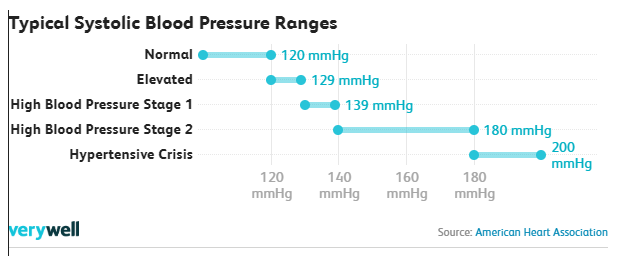

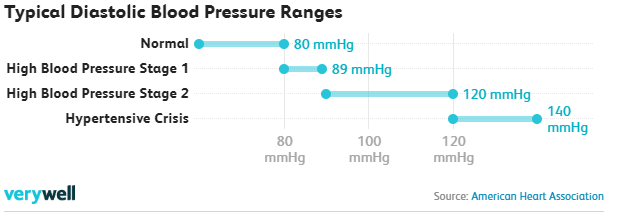

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Engineering</p></div>

In [143]:
df_prep = df_preprocessing.copy()

In [144]:
# changing gender to 0 and 1 (0 female, 1 male )
df_prep['gender'] = df_prep['gender'].apply( lambda x : 0 if x == 1 else 1)

# add feature IMC (BMI)
df_prep['IMC'] = df_prep['weight'] / ((df_prep['height']/100)**2)



IMC = Peso ÷ (Altura × Altura)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div>

In [145]:
train_raw, test_raw = train_test_split(df_prep, test_size=0.15, random_state=42)

# Imprimindo o tamanho dos conjuntos de treino, validação e teste
print(f"Tamanho do conjunto de treino: {train_raw.shape}")
print(f"Tamanho do conjunto de teste: {test_raw.shape}")

Tamanho do conjunto de treino: (59500, 14)
Tamanho do conjunto de teste: (10500, 14)


In [146]:
X_train = train_raw.drop(['id','cardio', 'weight','height'], axis=1)
y_train = train_raw['cardio']

X_test = test_raw.drop(['id','cardio', 'weight','height'], axis=1)
y_test = test_raw['cardio']

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Models</p></div>

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [148]:
# O que vamos testar?

Baseline (aleatório)
Logistic Regression
XGBoost
LightGBM
KNN Classifier
SVM

SyntaxError: invalid syntax (3720924079.py, line 4)

In [ ]:
# Cross validation
def CVS( model_name, model, training, kfold, verbose=False):
    xtraining = training.drop(['id','cardio', 'weight','height'], axis=1)
    ytraining = training['cardio']
        
    # model
    m = model.fit( xtraining, ytraining )
    
    accuracy_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='accuracy')
    precision_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='precision')
    recall_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='recall')
    f1_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='f1')
    
    mydict = {'Accuracy': round(accuracy_scores.mean(),3), 'Precision': round(precision_scores.mean(),3), 'Recall': round(recall_scores.mean(),3), 'F1 Score': round(f1_scores.mean(),3)}

    df_results = pd.DataFrame(data=mydict, index=[model_name]);

    return df_results

## Baseline

In [ ]:
#yhat_base_test = np.random.choice([0,1], size= y_test.shape[0])
#
#accuracy_base_test = accuracy_score(y_test, yhat_base_test)
#print(f"\nAcurácia nos dados de teste: {accuracy_base_test:.2f}")
#
#precision_base_test = precision_score( y_test, yhat_base_test)
#print(f'Precisão nos dados de teste: {precision_base_test:.2f}')
#
#f1_base_test = f1_score( y_test,yhat_base_test)
#print(f'F1-Score dos dados de teste: {f1_base_test:.2f}')

## Logistic Regression

In [ ]:
## model
#lr = LogisticRegression().fit(X_train, y_train)
#
## predicion
#yhat_lr = lr.predict( X_test )
#
## performance
#lr_accuracy_score = round(accuracy_score( y_test, yhat_lr ),3)
#lr_precision_score = round(precision_score( y_test, yhat_lr ),3)
#lr_recall_score = round(recall_score( y_test, yhat_lr),3)
#lr_f1 = round(f1_score(y_test, yhat_lr),3)
#
#lr_dict = {'Accuracy': lr_accuracy_score, 'Precision': lr_precision_score, 'Recall': lr_recall_score, 'F1 Score': lr_f1}
#df_lr = pd.DataFrame(data=lr_dict, index=['Logistic Regression'])

#### Logistic Regression - Cross Validation

In [ ]:
#df_lr_CV = CVS('Logistic Regression CV', lr , train_raw, kfold=5, verbose=False);

In [ ]:
#df_lr , df_lr_CV

## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
## Crie o modelo XGBoost
#xgb_model = xgb.XGBClassifier(
#    objective='binary:logistic',  # Para problemas de classificação binária
#    n_estimators=100,             # Número de árvores (estimadores)
#    max_depth=3,                  # Profundidade máxima das árvores
#    learning_rate=0.1,            # Taxa de aprendizado
#    random_state=42               # Semente aleatória para reprodutibilidade
#)
#
## Treine o modelo
#xgboost = xgb_model.fit(X_train, y_train)
#
#yhat_xgb = xgboost.predict( X_test )
#
## performance
#xgb_accuracy_score = round(accuracy_score( y_test, yhat_xgb ),3)
#xgb_precision_score = round(precision_score( y_test, yhat_xgb ),3)
#xgb_recall_score = round(recall_score( y_test, yhat_xgb),3)
#xgb_f1 = round(f1_score(y_test, yhat_xgb),3)
#
#xgb_dict = {'Accuracy': xgb_accuracy_score, 'Precision': xgb_precision_score, 'Recall': xgb_recall_score, 'F1 Score': xgb_f1}
#df_xgb = pd.DataFrame(data=xgb_dict, index=['XGBoost'])
#
#df_xgb

#### XGBoost - Cross Validation

In [ ]:
#df_xgb_CV = CVS('XGBoost CV', xgb_model , train_raw, kfold=5, verbose=False);

In [ ]:
#df_xgb , df_xgb_CV

## LightGBM

In [149]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

In [150]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


In [151]:
params = {
    'objective': 'binary',   # Definir o tipo de problema como binário
    'metric': 'binary_logloss',  # Métrica de avaliação
    'boosting_type': 'gbdt',  # Tipo de boosting (Gradient Boosting Decision Tree)
    'num_leaves': 31,         # Número máximo de folhas em uma árvore
    'learning_rate': 0.05,    # Taxa de aprendizado
    'feature_fraction': 0.9,  # Fração de características usadas para treinamento de cada árvore
    'bagging_fraction': 0.8,  # Fração de amostras usadas para treinamento de cada árvore
    'bagging_freq': 5,        # Frequência de amostragem
    'verbose': 0             # Controle da saída durante o treinamento
}


In [152]:
num_round = 100  # Número de rodadas (iterações)
lgbm_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

yhat_lgbm = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)  # Fazer previsões
yhat_binary_lgbm = [1 if pred > 0.5 else 0 for pred in yhat_lgbm]  # Converter probabilidades em classes binárias

# performance
lgbm_accuracy_score = round(accuracy_score( y_test, yhat_binary_lgbm ),5)
lgbm_precision_score = round(precision_score( y_test, yhat_binary_lgbm ),5)
lgbm_recall_score = round(recall_score( y_test, yhat_binary_lgbm),5)
lgbm_f1 = round(f1_score(y_test, yhat_binary_lgbm),5)

lgbm_dict = {'Accuracy': lgbm_accuracy_score, 'Precision': lgbm_precision_score, 'Recall': lgbm_recall_score, 'F1 Score': lgbm_f1}
df_lgbm = pd.DataFrame(data=lgbm_dict, index=['LightGBM'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [153]:
df_lgbm

,Accuracy,Precision,Recall,F1 Score
LightGBM,0.74124,0.76561,0.69932,0.73096


#### LightGBM - Cross Validation

In [154]:
# lgbm tem um módulo próprio para cross validation
cv_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=True, callbacks=[early_stopping(100), log_evaluation(100)])

# Encontre o melhor número de iterações
#best_num_iterations = len(cv_results['binary_logloss'])

# Treine o modelo com o número ideal de iterações
lgbm_cv = lgb.train(params, train_data, num_boost_round=1000)

# Use o modelo para fazer previsões
yhat_lgbm_cv = lgbm_model.predict(X_test)

yhat_binary_lgbm_cv = [1 if pred > 0.5 else 0 for pred in yhat_lgbm_cv]  # Converter probabilidades em classes binárias

# performance
lgbm_accuracy_score_cv = round(accuracy_score( y_test, yhat_binary_lgbm_cv ),5)
lgbm_precision_score_cv = round(precision_score( y_test, yhat_binary_lgbm_cv ),5)
lgbm_recall_score_cv = round(recall_score( y_test, yhat_binary_lgbm_cv),5)
lgbm_f1_cv = round(f1_score(y_test, yhat_binary_lgbm_cv),5)

lgbm_dict_cv = {'Accuracy': lgbm_accuracy_score_cv, 'Precision': lgbm_precision_score_cv, 'Recall': lgbm_recall_score_cv, 'F1 Score': lgbm_f1_cv}
df_lgbm_cv = pd.DataFrame(data=lgbm_dict_cv, index=['LightGBM CV'])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.539165 + 0

In [155]:
from sklearn.model_selection import GridSearchCV

In [156]:
train_raw, valid_raw = train_test_split(train_raw, test_size=0.15, random_state=42)

X_train = train_raw.drop(['id','cardio', 'weight','height'], axis=1)
y_train = train_raw['cardio']

X_valid = valid_raw.drop(['id','cardio', 'weight','height'], axis=1)
y_valid = valid_raw['cardio']

In [157]:
gridParams = { 
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [16,32, 64], 
    'random_state' : [501],
    'num_boost_round' : [3000],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4], 
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type = 'gbdt', 
                                   n_estimators=500, 
                                   learning_rate =  0.05, num_leaves =  64,  
                                   early_stopping_rounds=10)

g_lgbm = GridSearchCV(estimator=lgb_estimator, param_grid=gridParams, n_jobs = 3, cv= 3)

lgb_model = g_lgbm.fit(X=X_train, y=y_train, eval_set = (X_valid, y_valid))

yhat_lgb_model = lgb_model.predict(X_test)

yhat_binary_lgb_model_cv = [1 if pred > 0.5 else 0 for pred in yhat_lgb_model]

# performance
lgb_model_accuracy_score_cv = round(accuracy_score( y_test, yhat_binary_lgb_model_cv ),5)
lgb_model_precision_score_cv = round(precision_score( y_test, yhat_binary_lgb_model_cv ),5)
lgb_model_recall_score_cv = round(recall_score( y_test, yhat_binary_lgb_model_cv),5)
lgb_model_f1_cv = round(f1_score(y_test, yhat_binary_lgb_model_cv),5)

lgb_model_dict_cv = {'Accuracy': lgb_model_accuracy_score_cv, 'Precision': lgb_model_precision_score_cv, 'Recall': lgb_model_recall_score_cv, 'F1 Score': lgb_model_f1_cv}
df_lgb_model_cv = pd.DataFrame(data=lgb_model_dict_cv, index=['LightGBM CV - Grid'])

C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 25246, number of negative: 25329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 50575, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499179 -> in

In [163]:
df_lgbm, df_lgbm_cv, df_lgb_model_cv

(          Accuracy  Precision   Recall  F1 Score
 LightGBM   0.74124    0.76561  0.69932   0.73096,
              Accuracy  Precision   Recall  F1 Score
 LightGBM CV   0.74124    0.76561  0.69932   0.73096,
                     Accuracy  Precision   Recall  F1 Score
 LightGBM CV - Grid   0.74229    0.76636  0.70102   0.73224)

In [164]:
df_results = pd.concat([ df_lr_CV, df_xgb_CV, df_lgbm_cv, df_lgb_model_cv], ignore_index=False)
df_results

,Accuracy,Precision,Recall,F1 Score
Logistic Regression CV,0.70700,0.72100,0.67400,0.69700
XGBoost CV,0.73500,0.75500,0.69600,0.72400
LightGBM CV,0.74124,0.76561,0.69932,0.73096
LightGBM CV - Grid,0.74229,0.76636,0.70102,0.73224


## KNN Classifier

In [160]:
from sklearn.neighbors import KNeighborsClassifier

In [161]:
#knn_model = KNeighborsClassifier(n_neighbors=25)
#
#knn_class = knn_model.fit(X_train, y_train)
#
#yhat_knn = knn_class.predict(X_test)

In [96]:
#knn_accuracy_score = accuracy_score(y_test, yhat_knn)
#knn_precision_score = precision_score(y_test, yhat_knn)
#knn_recall_score = recall_score(y_test, yhat_knn)
#knn_f1 = f1_score(y_test, yhat_knn)
#
#knn_dict = {'Accuracy': knn_accuracy_score, 'Precision': knn_precision_score, 'Recall': knn_recall_score, 'F1 Score': knn_f1}
#df_knn = pd.DataFrame(data=knn_dict, index=['KNN Classifier'])
#
# df_knn

#### KNN Classifier (K-Nearest Neighbours Classifier) - Cross Validation

In [98]:
#df_knn_CV = CVS('KNN Classifier - CV', knn_model, train_raw, kfold=5, verbose=False );
#
#df_knn_CV

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

## SVM

In [100]:
from sklearn.svm import SVC

In [101]:
# linear
#svm_linear_model = SVC(kernel='linear')
#svm_linear = svm_linear_model.fit(X_train, y_train)
#yhat_svm_linear = svm_linear.predict(X_test)
#
#svm_linear_accuracy_score = accuracy_score(y_test, yhat_svm_linear)
#svm_linear_precision_score = precision_score(y_test, yhat_svm_linear)
#svm_linear_recall_score = recall_score(y_test, yhat_svm_linear)
#svm_linear_f1 = f1_score(y_test, yhat_svm_linear)
#
#svm_linear_dict = {'Accuracy': svm_linear_accuracy_score, 'Precision': svm_linear_precision_score, 'Recall': svm_linear_recall_score, 'F1 Score': svm_linear_f1}
#df_svm_linear = pd.DataFrame(data=svm_linear_dict, index=['SVM linear'])

In [102]:
# poly
#svm_poly_model = SVC(kernel='poly')
#svm_poly = svm_poly_model.fit(X_train, y_train)
#yhat_svm_poly = svm_poly.predict(X_test)
#
#svm_poly_accuracy_score = accuracy_score(y_test, yhat_svm_poly)
#svm_poly_precision_score = precision_score(y_test, yhat_svm_poly)
#svm_poly_recall_score = recall_score(y_test, yhat_svm_poly)
#svm_poly_f1 = f1_score(y_test, yhat_svm_poly)
#
#svm_poly_dict = {'Accuracy': svm_poly_accuracy_score, 'Precision': svm_poly_precision_score, 'Recall': svm_poly_recall_score, 'F1 Score': svm_poly_f1}
#df_svm_poly = pd.DataFrame(data=svm_poly_dict, index=['SVM poly'])

In [103]:
# rbf
#svm_rbf_model = SVC(kernel='rbf')
#svm_rbf = svm_rbf_model.fit(X_train, y_train)
#yhat_svm_rbf = svm_rbf.predict(X_test)
#
#svm_rbf_accuracy_score = accuracy_score(y_test, yhat_svm_rbf)
#svm_rbf_precision_score = precision_score(y_test, yhat_svm_rbf)
#svm_rbf_recall_score = recall_score(y_test, yhat_svm_rbf)
#svm_rbf_f1 = f1_score(y_test, yhat_svm_rbf)
#
#svm_rbf_dict = {'Accuracy': svm_rbf_accuracy_score, 'Precision': svm_rbf_precision_score, 'Recall': svm_rbf_recall_score, 'F1 Score': svm_rbf_f1}
#df_svm_rbf = pd.DataFrame(data=svm_rbf_dict, index=['SVM rbf'])

In [104]:
# sigmoidal

# Defina os valores que você deseja testar para coef0 e C
#param_grid = {
#    'coef0': [0.1, 0.2, 0.5],
#    'C': [0.1, 1, 10]
#}
#
## Crie o modelo SVM com kernel sigmoidal
#svm_sigmoidal_model = SVC(kernel='sigmoid', gamma='auto')
#
## Crie o objeto GridSearchCV
#grid_search = GridSearchCV(svm_sigmoidal_model, param_grid, cv=3, scoring='accuracy')
#
#svm_sigmoidal = grid_search.fit(X_train, y_train)
#
#best_params = grid_search.best_params_
#print("Melhores hiperparâmetros:", best_params)
#
## Use o melhor modelo para fazer previsões
#best_model = grid_search.best_estimator_
#yhat_svm_sigmoidal = best_model.predict(X_test)
#
#svm_sigmoidal_accuracy_score = accuracy_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_precision_score = precision_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_recall_score = recall_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_f1 = f1_score(y_test, yhat_svm_sigmoidal)
#
#svm_sigmoidal_dict = {'Accuracy': svm_sigmoidal_accuracy_score, 'Precision': svm_sigmoidal_precision_score, 'Recall': svm_sigmoidal_recall_score, 'F1 Score': svm_sigmoidal_f1}
#df_svm_sigmoidal = pd.DataFrame(data=svm_sigmoidal_dict, index=['SVM sigmoidal'])

Melhores hiperparâmetros: {'C': 0.1, 'coef0': 0.1}


In [105]:
#df_svm_compilado = pd.concat([df_svm_linear, df_svm_poly, df_svm_rbf ,df_svm_sigmoidal])
#
#df_svm_compilado



,Accuracy,Precision,Recall,F1 Score
SVM linear,0.727048,0.771377,0.649488,0.705205
SVM poly,0.727714,0.796083,0.616142,0.694649
SVM rbf,0.725429,0.778036,0.634900,0.699218
SVM sigmoidal,0.497524,1.000000,0.000379,0.000758


In [106]:
#df_results = pd.concat([df_results, df_svm_compilado])
#
#df_results

,Accuracy,Precision,Recall,F1 Score
Logistic Regression CV,0.707000,0.721000,0.674000,0.697000
XGBoost CV,0.735000,0.755000,0.696000,0.724000
LightGBM CV,0.741240,0.765610,0.699320,0.730960
LightGBM CV - Grid,0.742290,0.766360,0.701020,0.732240
SVM linear,0.727048,0.771377,0.649488,0.705205
SVM poly,0.727714,0.796083,0.616142,0.694649
SVM rbf,0.725429,0.778036,0.634900,0.699218
SVM sigmoidal,0.497524,1.000000,0.000379,0.000758


## Solution

In [167]:
- Temos que atualmente a empresa corre o risco de ter prejuízo com sua operação, dado a fórmula de custo.
- Para os casos de precisão = 55% o valor pago pelo consumidor é de R$ 500 mas o custo se mantém fixo em R$ 1000, dessa forma tem uma margem negativa de R$ 500 por diagnóstico.
- Para os casos de precisão = 60% o valor pago pelo consumidor é de R$ 1000 mas o custo se mantém fixo em R$ 1000, dessa forma se tem um breakeven, sem lucro ou prejuízo por diagnóstico.
- Para os casos de precisão = 65% o valor pago pelo consumidor é de R$ 1500 mas o custo se mantém fixo em R$ 1000, dessa forma tem uma margem positiva de R$ 500 por diagnóstico.

Se considerarmos proporções iguais entre esses 3 casos de precisão, temos que a operação não apresenta LUCRO, o que impede o investimento e crescimento do negócio.

Com os dados fornecidos, treinamos alguns modelos que podem ser aplicados e que trazem performances melhores do temos atualmente

SyntaxError: invalid syntax (87782282.py, line 1)

In [169]:
df_results = pd.concat([df_lgb_model_cv], ignore_index=False)

df_results

,Accuracy,Precision,Recall,F1 Score
LightGBM CV - Grid,0.74229,0.76636,0.70102,0.73224


In [ ]:
Usando o modelo de LightGBM com parâmetros encontrados com GridSearch, temos como resultados:
- 74% acuracia
- 76,6% de precisão

Com 76,6% de precisão do novo modelo seguindo as regras de custo, a Cardio Catch Diseases terá como lucro:
    75% -> valor pago pelo consumidor R$ 2500 , custo fixo operacao -> R$ 1000 , Lucro de R$ 1500 por diagnóstico
    
    Supondo um mês com 1000 diagnósticos sendo feitos, a empresa teria um lucro de R$ 1.500.000

# alterações:
- Negative pressure -> consider as typos and multiply by -1 (turn positive)
- add feature BMI (IMC), desconsider weight and height in modelling (worst results overall)
- showing only LightGBM Grid CV model results